In [1]:
%config InlineBackend.figure_format='retina'

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns;sns.set_style('whitegrid',{'grid.color':'0.95'})
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.stats import chi2
from scipy.stats import norm
from numpy.random import seed
from arch import arch_model

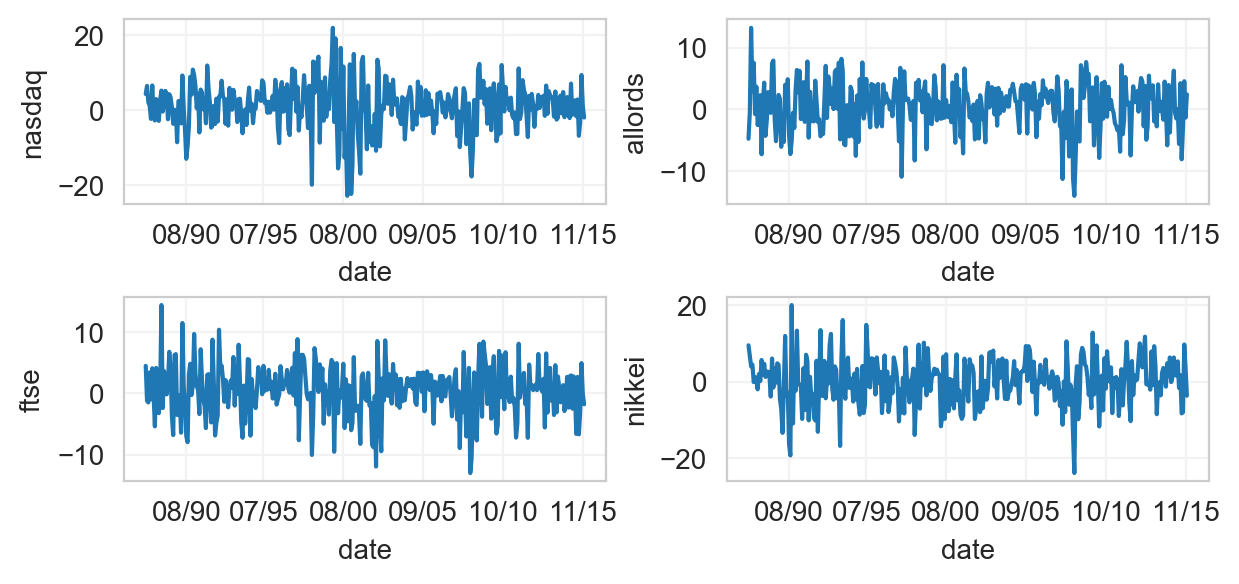

In [2]:
poe5csv='http://www.principlesofeconometrics.com/poe5/data/csv/'
ret=pd.read_csv(poe5csv+'returns5.csv',parse_dates=['dateid01'])
ret['date']=ret['dateid01'].dt.strftime('%m/%y')
ret=ret.set_index('date')
fig,ax=plt.subplots(2,2,figsize=(7,3))
fig.subplots_adjust(hspace=0.5,wspace=0.25)
sns.lineplot(x=ret.index,y=ret.nasdaq,ax=ax[0,0])
ax[0,0].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
sns.lineplot(x=ret.index,y=ret.allords,ax=ax[0,1])
ax[0,1].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
sns.lineplot(x=ret.index,y=ret.ftse,ax=ax[1,0])
ax[1,0].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
sns.lineplot(x=ret.index,y=ret.nikkei,ax=ax[1,1])
ax[1,1].xaxis.set_major_locator(mdates.MonthLocator(interval=2))

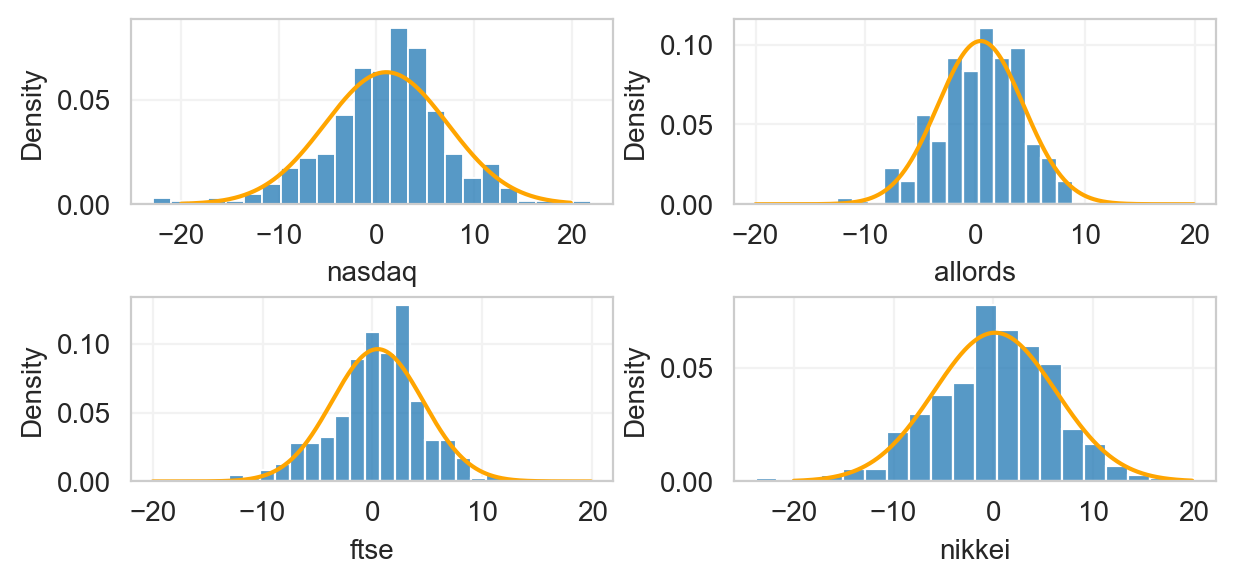

In [3]:
x=np.arange(-20,20,0.1)
fig,ax=plt.subplots(2,2,figsize=(7,3))
fig.subplots_adjust(hspace=0.5,wspace=0.25)
sns.histplot(ret.nasdaq,stat='density',ax=ax[0,0])
ax[0,0].plot(x,norm.pdf(x,ret.nasdaq.mean(),ret.nasdaq.std()),color='orange')
sns.histplot(ret.allords,stat='density',ax=ax[0,1])
ax[0,1].plot(x,norm.pdf(x,ret.allords.mean(),ret.allords.std()),color='orange')
sns.histplot(ret.ftse,stat='density',ax=ax[1,0])
ax[1,0].plot(x,norm.pdf(x,ret.ftse.mean(),ret.ftse.std()),color='orange')
sns.histplot(ret.nikkei,stat='density',ax=ax[1,1])
ax[1,1].plot(x,norm.pdf(x,ret.nikkei.mean(),ret.nikkei.std()),color='orange');

In [4]:
time=[]
for i in range(1,201):
    time.append(i)    
sim=pd.DataFrame(time)
sim=sim.rename(columns={0:'time'})
sim=sim.set_index(sim.time)
sim['e_arch']=np.nan
sim.iat[0,1]=0
seed(101010101)
sim['e']=np.random.standard_normal(200)
for i in range(1,201):
    sim['e_arch']=sim['e_arch'].fillna(sim.e*(1+0.8*(sim.e_arch.shift(i))**2)**0.5)
print(sim.describe(percentiles=[]).transpose())

        count        mean        std       min         50%         max
time    200.0  100.500000  57.879185  1.000000  100.500000  200.000000
e_arch  200.0   -0.164545   1.909360 -8.867216   -0.267976    9.207922
e       200.0   -0.146607   0.954817 -2.775370   -0.210830    2.785208


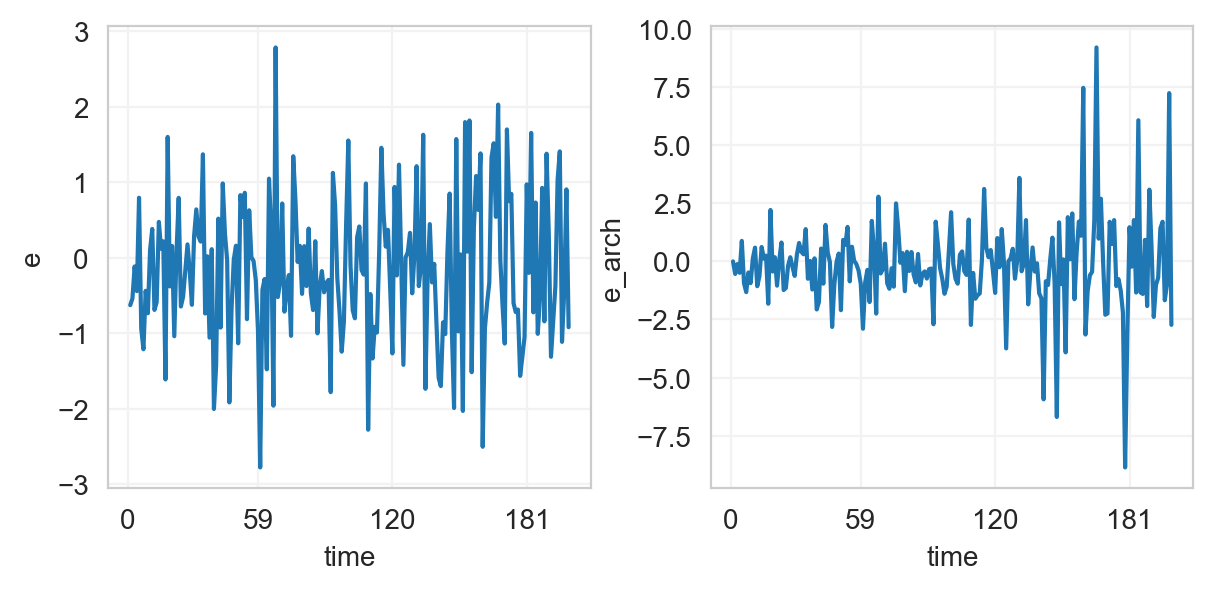

In [5]:
fig,ax=plt.subplots(1,2,figsize=(7,3))
fig.subplots_adjust(hspace=0.5,wspace=0.25)
sns.lineplot(sim.e,ax=ax[0])
ax[0].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
sns.lineplot(x=sim.index,y=sim.e_arch,ax=ax[1])
ax[1].xaxis.set_major_locator(mdates.MonthLocator(interval=2))

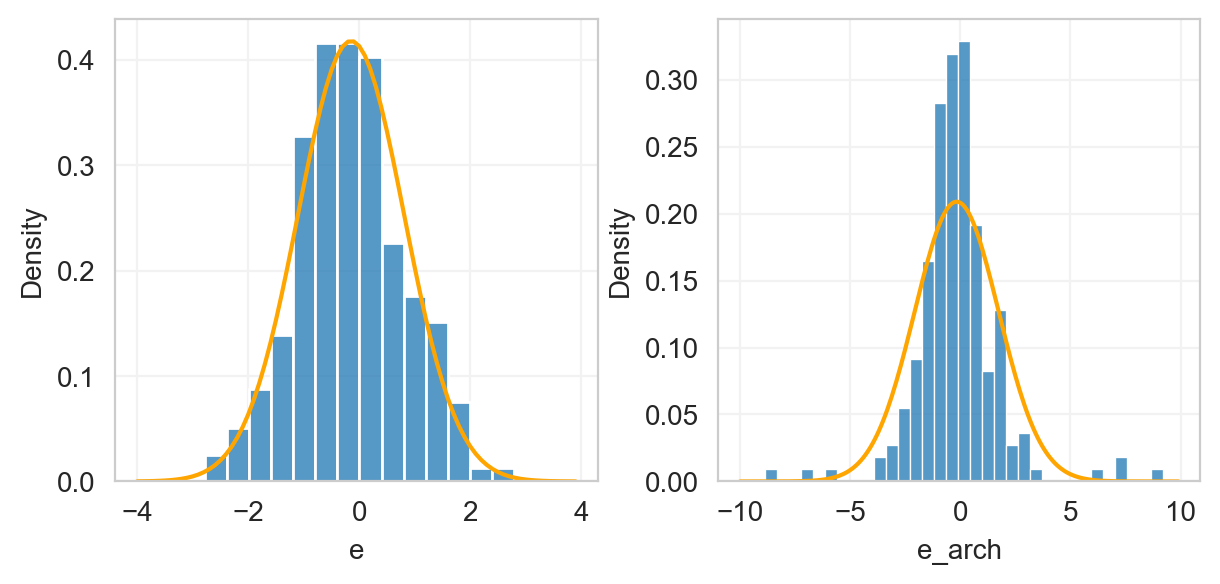

In [6]:
fig,ax=plt.subplots(1,2,figsize=(7,3))
fig.subplots_adjust(hspace=0.5,wspace=0.25)
x=np.arange(-4,4,0.1)
sns.histplot(sim.e,stat='density',ax=ax[0])
ax[0].plot(x,norm.pdf(x,sim.e.mean(),sim.e.std()),color='orange')
x=np.arange(-10,10,0.1)
sns.histplot(sim.e_arch,stat='density',ax=ax[1])
ax[1].plot(x,norm.pdf(x,sim.e_arch.mean(),sim.e_arch.std()),color='orange');

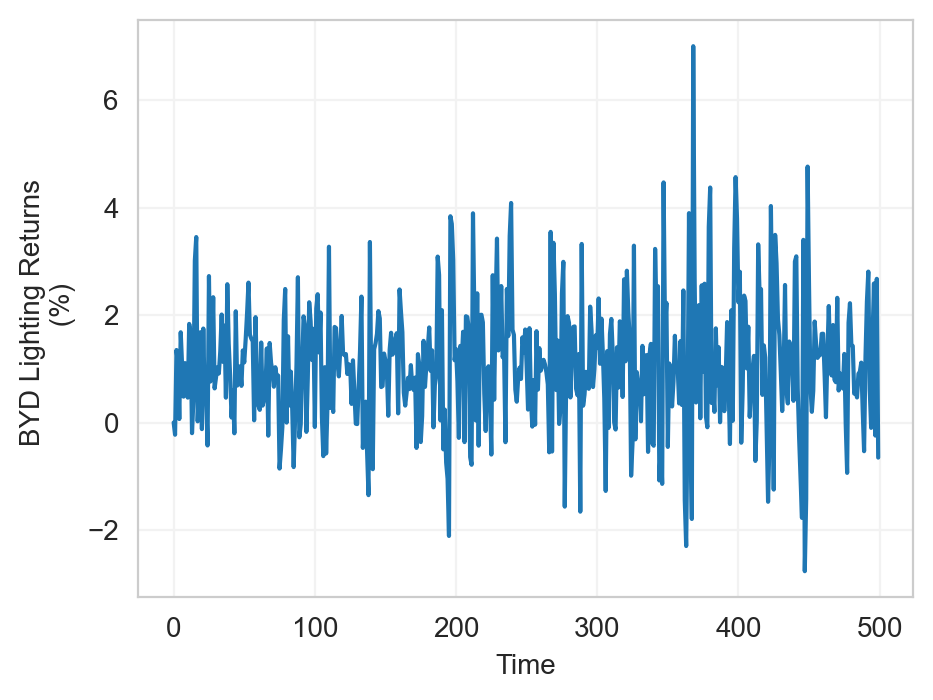

In [7]:
poe5csv='http://www.principlesofeconometrics.com/poe5/data/csv/'
byd=pd.read_csv(poe5csv+'byd.csv')
byd['time']=np.arange(0,500)
byd=byd.set_index('time')
ax=sns.lineplot(x=byd.index,y=byd.r)
ax.set(xlabel='Time',ylabel='BYD Lighting Returns \n (%)');

In [8]:
byd['Intercept']=1
res=sm.OLS(byd.r,byd.Intercept).fit()
byd['ehat']=res.resid
byd['ehat2']=byd.ehat**2
byd['L1ehat2']=byd.ehat2.shift(1)
res=smf.ols(formula='ehat2~L1ehat2',data=byd).fit()
print(res.summary().tables[0])

                            OLS Regression Results                            
Dep. Variable:                  ehat2   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     70.72
Date:                Fri, 13 Jun 2025   Prob (F-statistic):           4.39e-16
Time:                        12:11:49   Log-Likelihood:                -1154.2
No. Observations:                 499   AIC:                             2312.
Df Residuals:                     497   BIC:                             2321.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         


In [9]:
TR2=res.nobs*res.rsquared
pvalue=2*chi2.pdf(TR2,1,loc=0,scale=1)
crit=chi2.ppf(0.95,1)
print(f'TR2    =  {TR2:.6}')
print(f'pvalue =   {pvalue:.4}')
print(f'crit   =   {crit:.4}')

TR2    =  62.1595
pvalue =   3.217e-15
crit   =   3.841


In [10]:
res=smf.ols(formula='r~1',data=byd).fit()
print(res.summary().tables[1],'\n')
test=sm.stats.het_arch(res.resid,nlags=1)  
print(f'LM Test Stat for ARCH = {test[0]:.6}')
print(f'      pvalue          =  {test[1]:.4}')   

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0783      0.053     20.347      0.000       0.974       1.182

LM Test Stat for ARCH = 62.1595
      pvalue          =  3.167e-15


In [11]:
res=arch_model(byd.r,lags=1,vol='ARCH').fit()
print(res.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1829.9467953686626
Iteration:      2,   Func. Count:     12,   Neg. LLF: 971.789618039086
Iteration:      3,   Func. Count:     19,   Neg. LLF: 749.2009833966516
Iteration:      4,   Func. Count:     25,   Neg. LLF: 740.7799802832583
Iteration:      5,   Func. Count:     28,   Neg. LLF: 740.7799802833174
Optimization terminated successfully    (Exit mode 0)
            Current function value: 740.7799802832583
            Iterations: 5
            Function evaluations: 28
            Gradient evaluations: 5
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                      r   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -740.780
Distribution:                  Normal   AIC:                           1487.56
Method:            Maximum Likelihood 

In [12]:
byd['l1r']=byd.r.shift(1)
byd['mu']=res.params.iloc[0]
byd['omega']=res.params.iloc[1]
byd['alpha1']=res.params.iloc[2]
byd['harch']=byd.omega+byd.alpha1*(byd.l1r-byd.mu)**2
print(byd['harch'].tail())

time
495    1.412857
496    0.809904
497    1.971366
498    1.615733
499    2.125379
Name: harch, dtype: float64


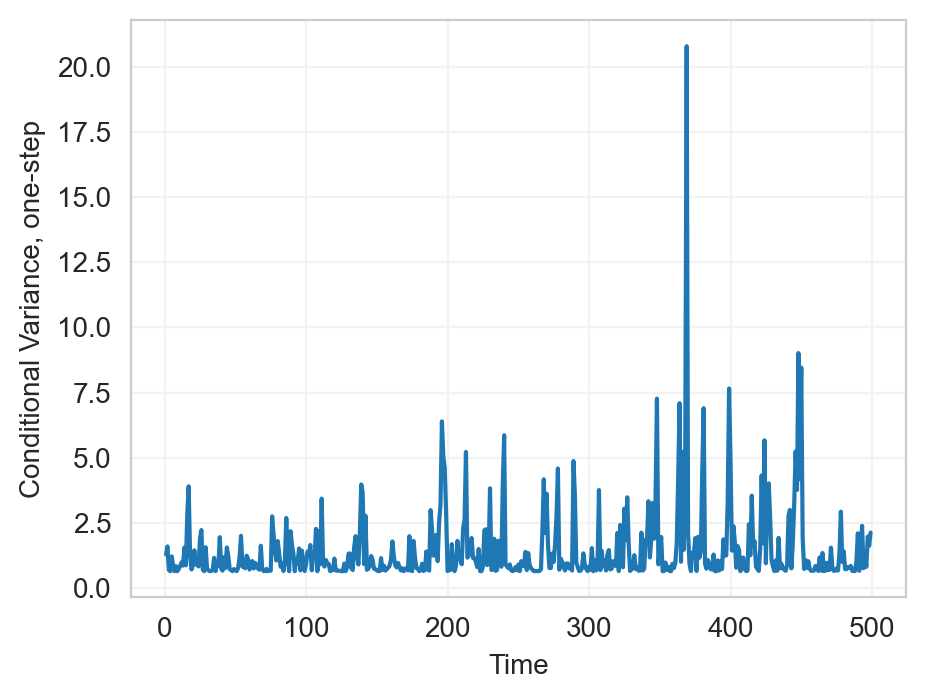

In [13]:
ax=sns.lineplot(x=byd.index,y=byd.harch)
ax.set(xlabel='Time',ylabel='Conditional Variance, one-step');

In [14]:
res=arch_model(byd.r,lags=1,vol='GARCH').fit()
print(res.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1694.1419420382333
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1616974.4137870488
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4485.200319534139
Iteration:      4,   Func. Count:     26,   Neg. LLF: 958.9483332478055
Iteration:      5,   Func. Count:     32,   Neg. LLF: 741.096253638545
Iteration:      6,   Func. Count:     38,   Neg. LLF: 742.0315189836559
Iteration:      7,   Func. Count:     44,   Neg. LLF: 736.3475516638009
Iteration:      8,   Func. Count:     50,   Neg. LLF: 736.0199918064578
Iteration:      9,   Func. Count:     55,   Neg. LLF: 736.0195776923877
Iteration:     10,   Func. Count:     60,   Neg. LLF: 736.0195397439875
Iteration:     11,   Func. Count:     64,   Neg. LLF: 736.0195397438986
Optimization terminated successfully    (Exit mode 0)
            Current function value: 736.0195397439875
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 1

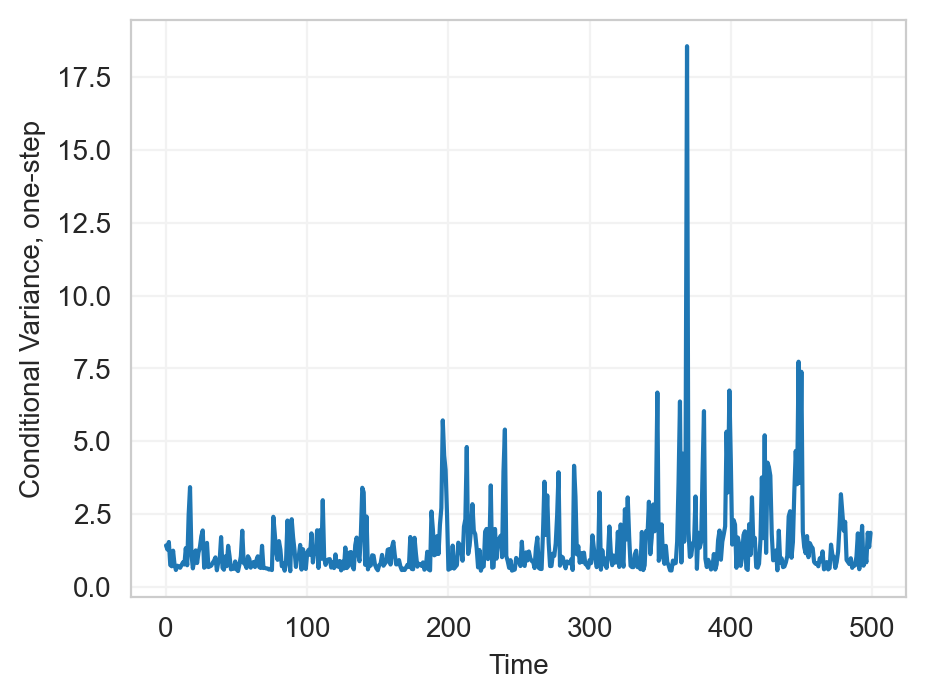

In [15]:
byd['l1r']=byd.r.shift(1)
byd['mu']=res.params.iloc[0]
byd['omega']=res.params.iloc[1]
byd['alpha1']=res.params.iloc[2]
byd['beta1']=res.params.iloc[3]
byd['htgarch']=np.nan
byd.iat[0,11]=1.42348
for i in range(1,201):
    byd['htgarch']=byd['htgarch'].fillna(byd.omega+byd.alpha1*(byd.l1r-byd.mu)**2+
                                         byd.beta1*byd.htgarch.shift(i))
ax=sns.lineplot(x=byd.index,y=byd.htgarch)
ax.set(xlabel='Time',ylabel='Conditional Variance, one-step');

In [16]:
res=arch_model(byd.r,p=1,q=1,o=1,power=2.0).fit()
print(res.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 162802921496.70416
Iteration:      2,   Func. Count:     16,   Neg. LLF: 142412510.11528096
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1875.59599346348
Iteration:      4,   Func. Count:     30,   Neg. LLF: 745.7208673203363
Iteration:      5,   Func. Count:     38,   Neg. LLF: 760.5643194776976
Iteration:      6,   Func. Count:     45,   Neg. LLF: 740.2363385698952
Iteration:      7,   Func. Count:     52,   Neg. LLF: 730.5769433390478
Iteration:      8,   Func. Count:     59,   Neg. LLF: 730.5471217052464
Iteration:      9,   Func. Count:     65,   Neg. LLF: 730.5461102334261
Iteration:     10,   Func. Count:     71,   Neg. LLF: 730.546092813752
Iteration:     11,   Func. Count:     76,   Neg. LLF: 730.5460928136094
Optimization terminated successfully    (Exit mode 0)
            Current function value: 730.546092813752
            Iterations: 11
            Function evaluations: 76
            Gradient evaluations: 11
